In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
prophet_results = []


def iter_metrics(path: Path):
    results: list[tuple[str, float]] = []
    for csv_path in path.iterdir():
        if csv_path.is_dir():
            # results += iter_metrics(csv_path)
            continue

        if csv_path.stem.startswith("model"):
            continue

        metrics = pd.read_csv(csv_path, index_col=0)
        for ticker in ["META", "ROST"]:
            if ticker in metrics.index:
                metrics = metrics.drop(ticker)
                
        if "prophet" in csv_path.stem and (
            "_q_" in csv_path.stem
            or "_m_" in csv_path.stem
            or csv_path.stem.endswith("_q")
            or csv_path.stem.endswith("_m")
        ):
            continue

        

        if "prophet" in csv_path.stem:
            prophet_results.append((csv_path.stem, metrics["mape"].mean()))
        else:
            results.append((csv_path.stem, metrics["mape"].mean()))

    return results


# results = []
# for csv_path in (Path("./") / "out").iterdir():
#     if csv_path.is_dir():

#     metrics = pd.read_csv(csv_path, index_col=0)
#     results.append((csv_path.stem, metrics["mape"].mean()))

results = sorted(
    iter_metrics(Path("./") / "out" / "vangja" / "val3"), key=lambda x: x[1]
)
prophet_results = sorted(prophet_results, key=lambda x: x[1])
results

# 01. LT(n=25,r=0.8,at=False) + FS(p=365.25,n=10,at=True) + C(l=-1,u=1,at=False) * FS(p=7,n=3,at=True)
# 02. LT(n=25,r=0.8,at=False) + FS(p=365.25,n=10,at=True)
# 03. LT(n=25,r=0.8,at=False) + FS(p=365.25,n=10,at=True) + BC(alpha=0.5,beta=0.5,l=-1,u=1,at=False) * FS(p=7,n=3,at=True)
# 04. LT(n=25,r=0.8,at=False) + FS(p=365.25,n=10,at=True) + FS(p=7,n=3,at=False)
# 05. LT(n=25,r=0.8,at=False) * (1 + FS(p=365.25,n=10,at=True) + C(l=-1,u=1,at=False) * FS(p=7,n=3,at=True))
# 06. LT(n=25,r=0.8,at=False) * (1 + FS(p=365.25,n=10,at=True))
# 07. LT(n=25,r=0.8,at=False) * (1 + FS(p=365.25,n=10,at=True) + FS(p=7,n=3,at=False))
# 08. LT(n=25,r=0.8,at=False) + FS(p=365.25,n=10,at=True) + FS(p=7,n=3,at=True)
# 09. LT(n=25,r=0.8,at=False) * (1 + FS(p=365.25,n=10,at=True) + BC(alpha=0.5,beta=0.5,l=-1,u=1,at=False) * FS(p=7,n=3,at=True))
# 10. LT(n=25,r=0.8,at=False) * (1 + FS(p=365.25,n=10,at=True) + FS(p=7,n=3,at=True))

[('108', 0.17968607106245532),
 ('111', 0.18115158113649926),
 ('109', 0.18326570295872802),
 ('112', 0.1835453086110107),
 ('88', 0.18769642970515765),
 ('91', 0.18791238912704974),
 ('92', 0.18829322444207042),
 ('110', 0.18844816869068015),
 ('89', 0.18922712243135234),
 ('90', 0.1919676981103044),
 ('150', 0.2234066526621763),
 ('127', 0.2357790878817214),
 ('130', 0.2388641379699639),
 ('147', 0.2415236957704338),
 ('128', 0.24242967568699175),
 ('148', 0.24262059798045363),
 ('149', 0.24672258470191458),
 ('151', 0.24694735583639654),
 ('129', 0.25651836697108693),
 ('131', 0.27012213227501103),
 ('13', 0.2749842366507317),
 ('12', 0.27500843893153704),
 ('11', 0.2753873140206803),
 ('10', 0.27659377910233046),
 ('52', 0.27932966439021045),
 ('53', 0.280323377549502),
 ('14', 0.2828727289851757),
 ('72', 0.2957160771146979),
 ('33', 0.297228571038192),
 ('32', 0.30079872831467386),
 ('31', 0.30179710120526154),
 ('30', 0.30251691472236397),
 ('2', 0.30601139423711926),
 ('69', 0.

In [3]:
def find_model(csv_file: Path):
    model_idx = csv_file.stem
    for idx in range(3):
        with open(csv_file.parent / f"model_idxs_{idx}.txt", "r") as f:
            lines = f.readlines()
            for line in lines:
                if len(line) == 0:
                    continue

                parts = line.split(",")
                if parts[0] != model_idx:
                    continue

                start = 10000
                end = -1
                for part_idx, part in enumerate(parts):
                    if "(" in part:
                        start = min(start, part_idx)

                    if ")" in part:
                        end = max(end, part_idx)

                return ",".join(parts[start:end + 1])
            
    return None

print(find_model(csv_file = Path("./") / "out" / "vangja" / "val3" / f"{108}.csv"))

folder = Path("./") / "out" / "vangja" / "val3"
my_results = {}
for result_file, mape in results:
    csv_file = folder / f"{result_file}.csv"
    if csv_file.is_file():
        my_results[result_file] = pd.read_csv(csv_file, index_col=0)
        print(f"{result_file}: {my_results[result_file]['mape'].mean()}")

index = my_results[result_file].index
my = []
models = set()
bad_files = []
bad_tickers = set()
for ticker in index:
    if ticker == "META" or ticker=="ROST":
        continue
    # best_my = [results.loc[ticker]["mape"] for results in my_results.values()]
    best_my = 1000
    best_model = ""
    for model, metrics in my_results.items():
        try:
            if metrics.loc[ticker]["mape"] < best_my:
                best_my = metrics.loc[ticker]["mape"]
                best_model = model
        except:
            bad_files.append(int(model))
            bad_tickers.add(ticker)

    my.append(best_my)
    models.add(find_model(folder / f"{best_model}.csv"))

sum(my) / len(my)

# 1. LT(n=25,r=0.8,at=False) + FS(p=365.25,n=10,at=True) + C(l=-1,u=1,at=False) * FS(p=7,n=3,at=True)
# 2. LT(n=25,r=0.8,at=False) + FS(p=365.25,n=10,at=True)
# 4. LT(n=25,r=0.8,at=False) * (1 + FS(p=365.25,n=10,at=True))

LT(n=25,r=0.8,at=False) + FS(p=365.25,n=10,at=True) + C(l=-1,u=1,at=False) * FS(p=7,n=3,at=True)

108: 0.17996509011159625
111: 0.1814290080669935
109: 0.18351890800714316
112: 0.18376646477715572
88: 0.18788030766882988
91: 0.18811031790419258
92: 0.18849503296968906
110: 0.18867668277154895
89: 0.1894369729914552
90: 0.19213870931355714
150: 0.22292698241474931
127: 0.23534423825039988
130: 0.23840684200509765
147: 0.24096748280224745
128: 0.24196433609837406
148: 0.24205867452522337
149: 0.2461528959217305
151: 0.24636748721583998
129: 0.2559931061987685
131: 0.2695490282089655
13: 0.27499476475166745
12: 0.27483574019306606
11: 0.27542228825377457
10: 0.27658270339962965
52: 0.28030530162591955
53: 0.28128317057478314
14: 0.2829199943894258
72: 0.2967216947650464
33: 0.2972849116472669
32: 0.30081032213226505
31: 0.3019292738493822
30: 0.30257270729091595
2: 0.3059974918098769
69: 0.3070837443847829
7: 0.30625701345044465
70: 0.307724556314589
27: 0.30680769973133204
73: 0.30810980

0.08122031732490667

In [4]:
models, len(models)

({'LT(n=25,r=0.8,at=False)\n',
  'LT(n=25,r=0.8,at=False) * (1 + BC(alpha=0.5,beta=0.5,l=-1,u=1,at=False) * FS(p=365.25,n=10,at=True) + BC(alpha=0.5,beta=0.5,l=-1,u=1,at=False) * FS(p=7,n=3,at=True))\n',
  'LT(n=25,r=0.8,at=False) * (1 + BC(alpha=0.5,beta=0.5,l=-1,u=1,at=False) * FS(p=365.25,n=10,at=True) + C(l=-1,u=1,at=False) * FS(p=7,n=3,at=True))\n',
  'LT(n=25,r=0.8,at=False) * (1 + BC(alpha=0.5,beta=0.5,l=-1,u=1,at=False) * FS(p=365.25,n=10,at=True) + FS(p=7,n=3,at=False))\n',
  'LT(n=25,r=0.8,at=False) * (1 + BC(alpha=0.5,beta=0.5,l=-1,u=1,at=False) * FS(p=365.25,n=10,at=True) + FS(p=7,n=3,at=True))\n',
  'LT(n=25,r=0.8,at=False) * (1 + BC(alpha=0.5,beta=0.5,l=-1,u=1,at=False) * FS(p=365.25,n=10,at=True))\n',
  'LT(n=25,r=0.8,at=False) * (1 + BC(alpha=0.5,beta=0.5,l=-1,u=1,at=False) * FS(p=7,n=3,at=True))\n',
  'LT(n=25,r=0.8,at=False) * (1 + C(l=-1,u=1,at=False) * FS(p=365.25,n=10,at=True) + C(l=-1,u=1,at=False) * FS(p=7,n=3,at=True))\n',
  'LT(n=25,r=0.8,at=False) * (1 + C(l=-

[0.17968607106245527, 0.16881727059397858, 0.16319514876133984, 0.15778675171305256, 0.14649783543628817, 0.14445236070510123, 0.14123380236680208, 0.14048655437103066, 0.13958945587029212, 0.1387971629598249, 0.11632792316477997, 0.11386198506546986, 0.11339912790470569, 0.1118648811850068, 0.11153008854968567, 0.11111141646692665, 0.11063016903439901, 0.11026754424216383, 0.10954482722702956, 0.10912234696135109, 0.09471651044877258, 0.09360138663723074, 0.0928617893710568, 0.09190269043169463, 0.08978437236060476, 0.08917831177973559, 0.08900756355183223, 0.08781515065038643, 0.08703962705723377, 0.08638962854743187, 0.08609922438699401, 0.08594386883329548, 0.08574105529147576, 0.08555669608843691, 0.0853677353390736, 0.08528096143100895, 0.08526211119179654, 0.08514926848787419, 0.08511619329241848, 0.08508347035109194, 0.08503880667577868, 0.08488778873557701, 0.08483816219517146, 0.08483816219517044, 0.08482898614331065, 0.08475764469744633, 0.0847222538483269, 0.084720552244125

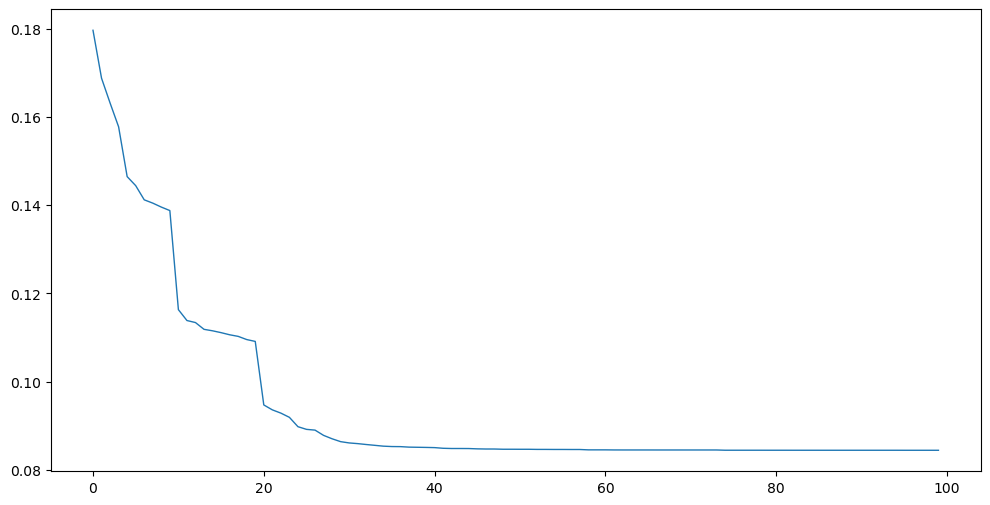

In [5]:
my_results = {}
score = []
len_models = []

for result_cnt in range(100):
    for result_file, mape in results[result_cnt:result_cnt + 1]:
        csv_file = Path("./") / "out" / "vangja" / "val3" / f"{result_file}.csv"
        if csv_file.is_file():
            my_results[result_file] = pd.read_csv(csv_file, index_col=0)
            # print(f"{result_file}: {my_results[result_file]['mape'].mean()}")

    index = my_results[result_file].index
    my = []
    models = set()
    bad_files = []
    bad_tickers = set()
    for ticker in index:
        if ticker == "META" or ticker=="ROST":
            continue
        # best_my = [results.loc[ticker]["mape"] for results in my_results.values()]
        best_my = 1000
        best_model = ""
        for model, metrics in my_results.items():
            try:
                if metrics.loc[ticker]["mape"] < best_my:
                    best_my = metrics.loc[ticker]["mape"]
                    best_model = model
            except:
                bad_files.append(int(model))
                bad_tickers.add(ticker)

        my.append(best_my)
        models.add(models.add(find_model(folder / f"{best_model}.csv")))

    score.append(sum(my) / len(my))
    len_models.append(len(models))

print(score)
print(len_models)
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(score))), score, lw=1)

In [51]:
score[19:]

[0.10912234696135109,
 0.09471651044877258,
 0.09360138663723074,
 0.0928617893710568,
 0.09190269043169463,
 0.08978437236060476,
 0.08917831177973559,
 0.08900756355183223,
 0.08781515065038643,
 0.08703962705723377,
 0.08638962854743187,
 0.08609922438699401,
 0.08594386883329548,
 0.08574105529147576,
 0.08555669608843691,
 0.0853677353390736,
 0.08528096143100895,
 0.08526211119179654,
 0.08514926848787419,
 0.08511619329241848,
 0.08508347035109194,
 0.08503880667577868,
 0.08488778873557701,
 0.08483816219517146,
 0.08483816219517044,
 0.08482898614331065,
 0.08475764469744633,
 0.0847222538483269,
 0.084720552244125,
 0.08466970820679638,
 0.08466958302278335,
 0.08466229740919876,
 0.08466229740919876,
 0.08463441431950573,
 0.08463225337026699,
 0.08462152720523414,
 0.08462095267364406,
 0.0846120933562508,
 0.08461209335625076,
 0.08453061850284765,
 0.0845306185028477,
 0.08453061850284764,
 0.08451001625997435,
 0.08450644689979017,
 0.0845062470659828,
 0.084506247065982

In [ ]:
print(s)

In [35]:
result_file, bad_tickers, len(bad_files), str(sorted(bad_files))

('104', set(), 0, '[]')

In [21]:
len(list(metrics.index)), len(index), len(metrics)

(437, 438, 437)

In [22]:
pd.read_csv("./out/vangja/val3/12.csv", index_col=0)

,mse,rmse,mae,mape
AFL,0.013319,0.115407,0.107245,0.117127
DOV,0.350490,0.592022,0.506353,0.497965
EFX,0.016775,0.129519,0.115722,0.107395
ETN,0.492069,0.701476,0.611570,0.666615
COF,0.109678,0.331177,0.296191,0.280260
...,...,...,...,...
GL,0.067538,0.259881,0.229052,0.223775
PGR,0.005280,0.072661,0.057238,0.059598
CPB,0.321930,0.567389,0.493836,0.476455
XEL,0.018750,0.136929,0.119183,0.104543


In [36]:
len(models), len(my)

(65, 436)

In [10]:
my_results.keys()

dict_keys(['108', '111', '109', '112', '88', '91', '92', '110', '89', '90', '150', '127', '130', '147', '128', '148', '149', '151', '129', '131', '12', '13', '11', '10', '52', '53', '14', '72', '30', '2', '7', '27', '69', '17', '70', '73', '71', '22', '64', '8', '86', '23', '5', '60', '62', '0', '6', '1', '28', '83', '18', '84', '101', '21', '25', '26', '114', '55', '16', '61', '74', '76', '3', '75', '81', '132', '67', '98', '125', '78', '56', '142', '137', '120', '103', '117', '153', '20', '106', '15', '113', '123', '93', '66', '59', '143', '99', '65', '145', '118', '138', '4', '57', '96', '54', '94', '152', '135', '79', '133', '19', '140', '85', '119', '102', '97', '58', '124', '136', '9', '122', '24', '134', '100', '87', '63', '141', '115', '146', '95', '121', '29', '107', '68', '144', '126', '116', '155', '80', '139', '82', '77', '154', '105', '104'])

In [12]:
index, result_file

(Index(['VTR', 'VNO', 'LEN', 'RCL', 'HST', 'NRG', 'HAL', 'SYY', 'JBHT', 'HOLX',
        ...
        'AEP', 'PCAR', 'PH', 'XYL', 'KIM', 'WFC', 'MSFT', 'JCI', 'V', 'PSA'],
       dtype='object', length=438),
 '104')

In [7]:
metrics.loc[ticker]

,mse,rmse,mae,mape
y,0.010506,0.102497,0.086301,0.097043
y,0.082645,0.287481,0.263404,0.261336
y,0.051975,0.227980,0.199500,0.191852
y,0.012937,0.113741,0.098836,0.104326
y,0.147980,0.384682,0.307341,0.223136
...,...,...,...,...
y,0.001754,0.041883,0.033544,0.031173
y,0.062964,0.250927,0.222745,0.195239
y,0.026186,0.161822,0.140852,0.143105
y,0.038068,0.195111,0.152385,0.158879


In [25]:
len(results), len(models)

(591, 172)

442


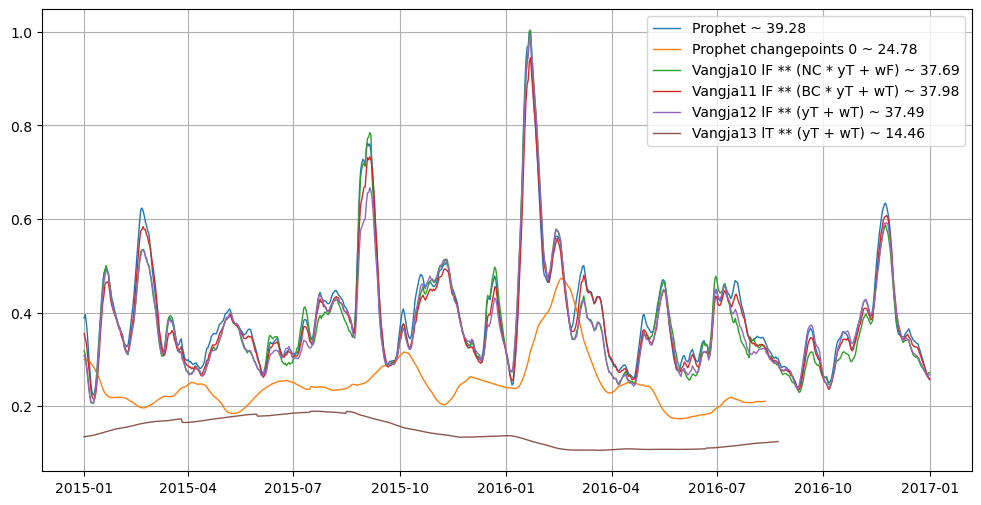

In [35]:
# test10 - NC * yT + wF
# test11 - BC * yT + wT
dates = []
dates2 = []
vangja_dates = []
vangja2_dates = []
vangja3_dates = []
vangja4_dates = []
mapes = []
mapes2 = []
vangja_mapes = []
vangja2_mapes = []
vangja3_mapes = []
vangja4_mapes = []

index = None

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"prophet_{point_str}_multiplicative_w"
    csv_path = Path("./") / "out" / "prophet" / "test" / f"{model_name}.csv"
    vangja_path = Path("./") / "out" / "vangja" / "test10" / f"{point_str}.csv"
    if not csv_path.is_file() or not vangja_path.is_file():
        continue

    index_1 = pd.read_csv(csv_path, index_col=0).index
    index_2 = pd.read_csv(vangja_path, index_col=0).index
    index_1 = index_1.intersection(index_2)
    if index is None:
        index = index_1

    index = index.intersection(index_1)

print(len(index))
prophet_metrics_per_ticker = {}
vangja_metrics_per_ticker = {}

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"prophet_{point_str}_multiplicative_w"
    csv_path = Path("./") / "out" / "prophet" / "test" / f"{model_name}.csv"
    csv2_path = Path("./") / "out" / "prophet" / "test2" / f"prophet_{point_str}_multiplicative_lt0_w.csv"
    vangja_path = Path("./") / "out" / "vangja" / "test10" / f"{point_str}.csv"
    vangja2_path = Path("./") / "out" / "vangja" / "test11" / f"{point_str}.csv"
    vangja3_path = Path("./") / "out" / "vangja" / "test12" / f"{point_str}.csv"
    vangja4_path = Path("./") / "out" / "vangja" / "test13" / f"{point_str}.csv"

    if not csv_path.is_file():
        continue

    dates.append(point)
    prophet_metrics = pd.read_csv(csv_path, index_col=0)
    mapes.append(prophet_metrics["mape"].mean())

    


    if not vangja_path.is_file():
        continue

    vangja_metrics = pd.read_csv(vangja_path, index_col=0)
    vangja_dates.append(point)
    vangja_mapes.append(vangja_metrics["mape"].mean())

    # for ticker in index:
    #     prophet_metrics_per_ticker[ticker] = prophet_metrics_per_ticker.get(
    #         ticker, []
    #     ) + [prophet_metrics.loc[ticker]["mape"]]
    #     vangja_metrics_per_ticker[ticker] = vangja_metrics_per_ticker.get(
    #         ticker, []
    #     ) + [vangja_metrics.loc[ticker]["mape"]]

    if not vangja2_path.is_file():
        continue

    vangja2_metrics = pd.read_csv(vangja2_path, index_col=0)
    vangja2_dates.append(point)
    vangja2_mapes.append(vangja2_metrics["mape"].mean())

    if not vangja3_path.is_file():
        continue

    vangja3_metrics = pd.read_csv(vangja3_path, index_col=0)
    vangja3_dates.append(point)
    vangja3_mapes.append(vangja3_metrics["mape"].mean())

    if not vangja4_path.is_file():
        continue

    vangja4_metrics = pd.read_csv(vangja4_path, index_col=0)
    vangja4_dates.append(point)
    vangja4_mapes.append(vangja4_metrics["mape"].mean())

    if not csv2_path.is_file():
        continue

    dates2.append(point)
    prophet_metrics = pd.read_csv(csv2_path, index_col=0)
    mapes2.append(prophet_metrics["mape"].mean())

    

plt.figure(figsize=(12, 6))
plt.plot(dates, mapes, lw=1, label=f"Prophet ~ {100 * sum(mapes) / len(mapes):.2f}")
plt.plot(dates2, mapes2, lw=1, label=f"Prophet changepoints 0 ~ {100 * sum(mapes2) / len(mapes2):.2f}")
plt.plot(
    vangja_dates,
    vangja_mapes,
    lw=1,
    label=f"Vangja10 lF ** (NC * yT + wF) ~ {100 * sum(vangja_mapes) / len(vangja_mapes):.2f}",
)
plt.plot(
    vangja2_dates,
    vangja2_mapes,
    lw=1,
    label=f"Vangja11 lF ** (BC * yT + wT) ~ {100 * sum(vangja2_mapes) / len(vangja2_mapes):.2f}",
)
plt.plot(
    vangja3_dates,
    vangja3_mapes,
    lw=1,
    label=f"Vangja12 lF ** (yT + wT) ~ {100 * sum(vangja3_mapes) / len(vangja3_mapes):.2f}",
)
plt.plot(
    vangja4_dates,
    vangja4_mapes,
    lw=1,
    label=f"Vangja13 lT ** (yT + wT) ~ {100 * sum(vangja4_mapes) / len(vangja4_mapes):.2f}",
)
plt.grid()
plt.legend()

In [31]:
max(vangja4_mapes), min(vangja4_mapes)

(0.18940937580164943, 0.10593231072545882)

In [39]:
(pd.DataFrame(prophet_metrics_per_ticker).mean() - pd.DataFrame(vangja_metrics_per_ticker).mean()).sort_values(ascending=False).iloc[:380]

CF      0.080433
UAA     0.067014
WYNN    0.061479
MOS     0.057299
FCX     0.052467
          ...   
DHR     0.003513
EIX     0.003484
RSG     0.003438
PSX     0.003223
LYV     0.003138
Length: 380, dtype: float64

In [56]:
ti = pd.DataFrame(prophet_metrics_per_ticker).mean().sort_values().index

In [61]:
pd.DataFrame(prophet_metrics_per_ticker).mean()["UNH"], pd.DataFrame(vangja_metrics_per_ticker).mean()["UNH"]

(0.24384666203119232, 0.21951790229681753)

In [69]:
(
    (
        pd.DataFrame(prophet_metrics_per_ticker).mean().loc[ti]
        - pd.DataFrame(vangja_metrics_per_ticker).mean().loc[ti]
    )
    / pd.DataFrame(prophet_metrics_per_ticker).mean().loc[ti]
).sort_values(ascending=False)

UNH     0.099771
CF      0.096638
LEG     0.093062
CAH     0.091181
TPR     0.089200
          ...   
MA     -0.031540
PG     -0.034188
CTAS   -0.034577
V      -0.046210
TAP    -0.054254
Length: 442, dtype: float64

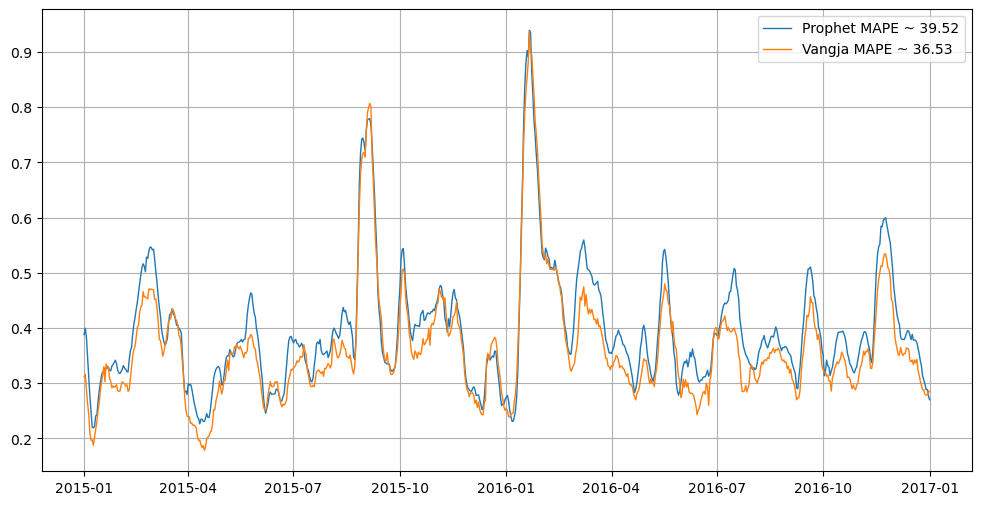

In [72]:

# best = (pd.DataFrame(prophet_metrics_per_ticker).mean() - pd.DataFrame(vangja_metrics_per_ticker).mean()).sort_values(ascending=False).iloc[:200].index
best = (
    (
        pd.DataFrame(prophet_metrics_per_ticker).mean().loc[ti]
        - pd.DataFrame(vangja_metrics_per_ticker).mean().loc[ti]
    )
    / pd.DataFrame(prophet_metrics_per_ticker).mean().loc[ti]
).sort_values(ascending=False).iloc[:50].index
dates = []
vangja_dates = []
mapes = []
vangja_mapes = []

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"prophet_{point_str}_multiplicative_w"
    csv_path = Path("./") / "out" / "prophet" / "test" / f"{model_name}.csv"
    vangja_path = Path("./") / "out" / "vangja" / "test10" / f"{point_str}.csv"
    if not csv_path.is_file() or not vangja_path.is_file():
        continue

    dates.append(point)
    prophet_metrics = pd.read_csv(csv_path, index_col=0).loc[best]
    mapes.append(prophet_metrics["mape"].mean())
    if not vangja_path.is_file():
        continue

    vangja_metrics = pd.read_csv(vangja_path, index_col=0).loc[best]
    vangja_dates.append(point)
    vangja_mapes.append(vangja_metrics["mape"].mean())

plt.figure(figsize=(12, 6))
plt.plot(dates, mapes, lw=1, label=f"Prophet MAPE ~ {100 * sum(mapes) / len(mapes):.2f}")
plt.plot(vangja_dates, vangja_mapes, lw=1, label=f"Vangja MAPE ~ {100 * sum(vangja_mapes) / len(vangja_mapes):.2f}")
plt.grid()
plt.legend()

In [37]:
prophet_metrics_per_ticker["NRG"]

[0.6602629960815104,
 0.8690505326626856,
 0.664686055294643,
 1.0929526245791368,
 0.9524554900491292]

In [186]:
pd.DataFrame(vangja_metrics_per_ticker).mean().sort_values()

CLX     0.120702
RSG     0.154542
PEP     0.183628
T       0.188831
LMT     0.191420
          ...   
CF      0.986732
NCLH    1.021120
MU      1.025952
WMB     1.117796
FCX     1.489121
Length: 442, dtype: float64

In [24]:
pd.Series(mapes).describe()

count    664.000000
mean       0.393368
std        0.117633
min        0.224099
25%        0.316248
50%        0.365206
75%        0.437891
max        1.000289
dtype: float64

In [25]:
pd.Series(vangja_mapes).describe()

count    664.000000
mean       0.376859
std        0.120885
min        0.205629
25%        0.297395
50%        0.348706
75%        0.414936
max        1.002883
dtype: float64

In [63]:
idx = -3
mapes[idx], vangja_mapes[idx]

(0.29075288763021745, 0.28838827693962354)

In [11]:
prophet_results

[('prophet_2014_additive_smp_w', 0.3424672522092445),
 ('prophet_2014_multiplicative', 0.34297307555725365),
 ('prophet_2014_additive', 0.34297307555725365),
 ('prophet_2014_multiplicative_smp_w', 0.3429744903837415),
 ('prophet_2014_multiplicative_w', 0.3435770094405776),
 ('prophet_2014_multiplicative_w_smp_w', 0.343579222809886),
 ('prophet_2014_additive_w_smp_w', 0.3440900353036296),
 ('prophet_2014_additive_w', 0.34409536999613793),
 ('prophet_results_2014', 0.34409536999613793),
 ('prophet_2014_additive_smp_w_smp_yearly', 0.34437501284607647),
 ('prophet_2014_additive_smp_yearly', 0.34445651708100083),
 ('prophet_2014_multiplicative_smp_yearly', 0.3467905698311062),
 ('prophet_results_w_smp_y_2014', 0.34681218584434825),
 ('prophet_2014_multiplicative_w_smp_yearly', 0.3469819922043038),
 ('prophet_2014_multiplicative_w_smp_w_smp_yearly', 0.347045333511293),
 ('prophet_2014_additive_w_smp_w_smp_yearly', 0.3471004307111387),
 ('prophet_2014_additive_w_smp_yearly', 0.347101687984614

In [10]:
for result in results:
    if "True" not in result[0]:
        print(result)

('vangja_same_30_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_linear_70_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_linear_40_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_same_10_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_linear_60_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_simple_80_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_simple_60_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_linear_80_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_linear_30_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_simple_70_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_simple_40_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_simple_10_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_simple_30_LT(n_25_r_0_8_at_False_complete)', 0.33624783455055207)
('vangja_same_20_LT(n_25_r_0_

In [22]:
prophet_results = {}

for result_file in [
    "prophet_results_2014.csv",
    "prophet_results_default_2014.csv",
    "prophet_results_default_smp_2014.csv",
]:
    prophet_results[result_file] = pd.read_csv(Path("./") / result_file, index_col=0)

for result_file in prophet_results.keys():
    print(f"{result_file}: {prophet_results[result_file]['mape'].mean()}")

prophet_results_2014.csv: 26.3301940204345
prophet_results_default_2014.csv: 0.3435770094405776
prophet_results_default_smp_2014.csv: 0.3468237309926702


In [16]:
(prophet_results["prophet_results_2014.csv"]["mape"].min(),
prophet_results["prophet_results_2014.csv"]["mape"].max(),
prophet_results["prophet_results_2014.csv"]["mape"].mean())

(0.9605224438074478, 661.8497201295756, 26.3301940204345)

In [24]:
my_results = {}

for result_file in [
    "my_result_linear_2014.csv",
    # "my_result_same_2014.csv",
    # "my_result_simple_2014.csv",
]:
    my_results[result_file] = pd.read_csv(Path("./") / result_file, index_col=0)
    print(f"{result_file}: {my_results[result_file]['mape'].mean()}")

my_result_linear_2014.csv: 0.27082506370387294


In [66]:
my_results[result_file]

,mse,rmse,mae,mape
PRGO,0.060717,0.246408,0.211053,0.216011
INCY,0.168545,0.410543,0.367722,0.349816
ED,0.032185,0.179403,0.148304,0.140498
CDNS,0.005822,0.076303,0.055513,0.047230
SHW,0.065807,0.256529,0.223741,0.195271
...,...,...,...,...
FE,0.002496,0.049958,0.042216,0.045426
EVRG,0.012768,0.112996,0.101321,0.086837
UAL,0.335582,0.579295,0.512152,0.407554
DFS,0.008021,0.089560,0.066776,0.059575


In [25]:
index = my_results[result_file].index
prophet = []
my = []
for ticker in index:
    best_prophet = [results.loc[ticker]["mape"] for results in prophet_results.values()]
    best_my = [results.loc[ticker]["mape"] for results in my_results.values()]
    prophet.append(min(best_prophet))
    my.append(min(best_my))

In [26]:
sum(prophet) / len(prophet)

0.3311428929528097

In [27]:
sum(my) / len(my)

0.27082506370387294

In [39]:
len(prophet), len(my)

(437, 437)

In [46]:
min(best_prophet)

0.3126770053180203